In [1]:
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Initialize empty lists to store the separated columns
dates = []
times = []
sensor_ids = []
statuses = []
activities = []

# Read the raw data file line by line
with open('/Users/techonn/Desktop/UoM/Dissertation/Data/aruba/data', 'r') as file:
    for line in file:
        # Split the line by whitespace
        columns = re.split(r'\s+', line.strip())
        
        # Check if the line has enough columns
        if len(columns) >= 4:
            # Separate the columns and append to respective lists
            date = columns[0]
            time = columns[1]
            sensor_id = columns[2]
            status = columns[3]
            activity = ' '.join(columns[4:]) if len(columns) > 4 else ""
            
            dates.append(date)
            times.append(time)
            sensor_ids.append(sensor_id)
            statuses.append(status)
            activities.append(activity)

# Create a DataFrame from the separated columns
data = pd.DataFrame({
    'Date': dates,
    'Time': times,
    'Sensor_ID': sensor_ids,
    'Status': statuses,
    'Activity': activities
})

# Display the separated data

print(data)

               Date             Time Sensor_ID Status        Activity
0        2010-11-04  00:03:50.209589      M003     ON  Sleeping begin
1        2010-11-04  00:03:57.399391      M003    OFF                
2        2010-11-04  00:15:08.984841      T002   21.5                
3        2010-11-04  00:30:19.185547      T003     21                
4        2010-11-04  00:30:19.385336      T004     21                
...             ...              ...       ...    ...             ...
1719553  2011-06-11   23:42:59.28507      T002   25.5                
1719554  2011-06-11  23:48:02.888409      T001   23.5                
1719555  2011-06-11  23:48:02.988798      T002     25                
1719556  2011-06-11    23:53:06.4292      T002   25.5                
1719557  2011-06-11  23:58:10.004834      T002     25    Sleeping end

[1719558 rows x 5 columns]


In [3]:
unique_dates = data['Date'].unique()
print(len(unique_dates))

220


## Data Preprocessing

In [4]:
# Drop the 'Sensor_ID' and 'Status' columns
data = data.drop(['Sensor_ID', 'Status','Time'], axis=1)

data = data[data['Activity'] != '']

In [5]:
# Remove the 'respirate' activity from the 'Activity' column
data = data[data['Activity'] != 'Respirate begin']
data = data[data['Activity'] != 'Respirate end']

In [6]:
# Drop the rows with activities ending with 'end'
data = data[~data['Activity'].str.endswith('end')]

In [7]:
duplicated_rows = data['Activity'].shift() == data['Activity']
data = data[~duplicated_rows]

In [8]:
data['Activity'] = data['Activity'].str.replace(' begin', '')

In [9]:
# Get the rows for the date 2011-05-23
date_data = data[data['Date'] == '2011-05-23']

# Calculate the number of rows for that date
num_rows = len(date_data)

# Calculate the index of the middle row
middle_index = num_rows // 2

# Slice the DataFrame to keep only the rows up to the middle index
date_data = date_data.iloc[:middle_index]

# Update the original DataFrame with the sliced data for the date 2011-05-23
data[data['Date'] == '2011-05-23'] = date_data

In [10]:
# Remove NaN values from every column
data = data.dropna()

In [11]:
# Remove dates with less than 5 instances of activity
activity_counts_per_date = data['Date'].value_counts()
dates_to_keep = activity_counts_per_date[activity_counts_per_date >= 5].index
data = data[data['Date'].isin(dates_to_keep)]

In [12]:
print(data)

               Date          Activity
0        2010-11-04          Sleeping
52       2010-11-04     Bed_to_Toilet
68       2010-11-04          Sleeping
266      2010-11-04  Meal_Preparation
934      2010-11-04             Relax
...             ...               ...
1716681  2011-06-11             Relax
1718341  2011-06-11              Work
1718402  2011-06-11  Meal_Preparation
1718684  2011-06-11             Relax
1719500  2011-06-11          Sleeping

[3916 rows x 2 columns]


## Split dataset

In [243]:
# Obtain unique dates to split dataset into test and training set
unique_dates = data['Date'].unique()

# Calculate the number of unique dates
num_unique_dates = len(unique_dates)

train_split_index = int(num_unique_dates * 0.14)
val_split_index = int(num_unique_dates * 0.28)

# Split the dataset based on the calculated indices
train_data = data[data['Date'] <= unique_dates[train_split_index]]
val_data = data[(data['Date'] > unique_dates[train_split_index]) & (data['Date'] <= unique_dates[val_split_index])]
test_data = data[data['Date'] > unique_dates[val_split_index]]

# Reset the index of the DataFrames
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [244]:
unique = test_data['Date'].unique()
print(len(unique))

157


In [245]:
# Set the display option to show all rows
pd.set_option('display.max_rows', None)
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

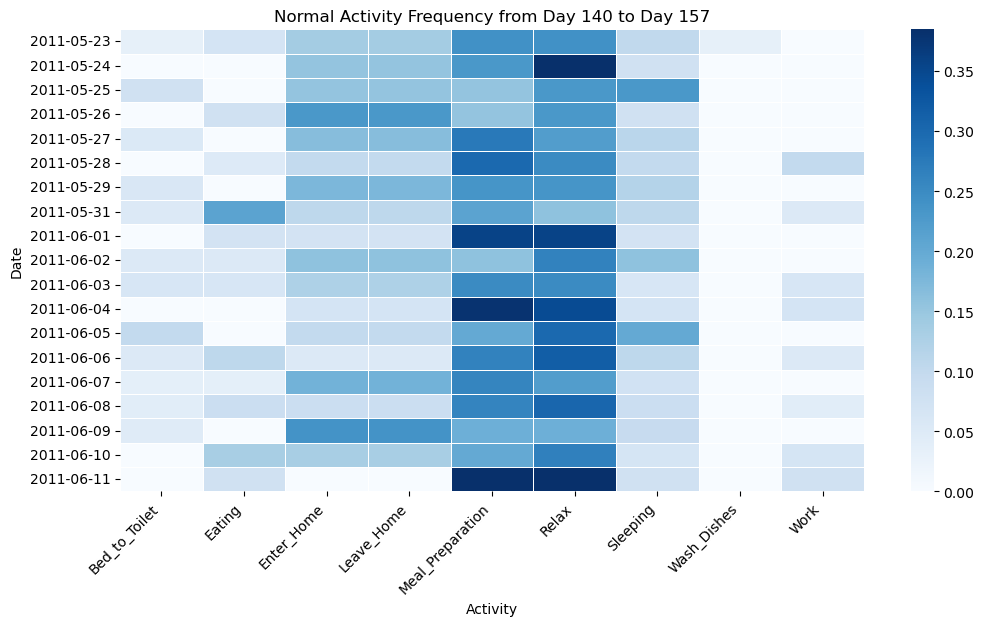

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'test_data' with columns 'Date' and 'Activity'
# Make sure 'Date' column is in datetime format

# Filter the test data for days 140 to 158
start_date = unique_dates[val_split_index + 139]
end_date = unique_dates[val_split_index + 157]
filtered_data = test_data[(test_data['Date'] >= start_date) & (test_data['Date'] <= end_date)]

# Create a pivot table for activity counts
activity_counts = filtered_data.pivot_table(index='Date', columns='Activity', aggfunc='size', fill_value=0)

# Normalize the activity counts for better visualization
activity_freq = activity_counts.div(activity_counts.sum(axis=1), axis=0)

# Set up the figure
plt.figure(figsize=(12, 6))

# Create a heatmap using seaborn
sns.heatmap(activity_freq, cmap="Blues", linewidths=0.5, linecolor='white')

# Customize labels and title
plt.xlabel('Activity')
plt.ylabel('Date')
plt.title('Normal Activity Frequency from Day 140 to Day 157')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


## MCI ANOMALY (GRADUAL)

### Sleep Disruption (Day 80 to 99 - total 20 days)

In [247]:
# Step 1: Identify the data in the test dataset from day 80 to 99 and isolate it
sleep_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 79]) & 
                             (test_data['Date'] <= unique_dates[val_split_index + 98])]

# Step 2: Randomly select 7 days to introduce the anomaly
random_sleep_days = random.sample(list(sleep_days['Date'].unique()), 10)

# Step 3: Simulate the anomaly sequence for unorganized activity pattern
modified_dfs = []

for date, day_data in sleep_days.groupby('Date'):
    if date in random_sleep_days:
        print(f"Anomaly introduced for date: {date}")  # Print the date with the anomaly
        
        # Simulate sleep disruption by inserting the anomaly sequence
        anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            # Insert the anomaly sequence after the first activity
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(anomaly_sequence),
                                                   'Activity': anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            modified_dfs.append(modified_df)
        else:
            # Insert the anomaly sequence before the first activity
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(anomaly_sequence),
                                                   'Activity': anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
sleep_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 79]],
                       sleep_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 98]]])


Anomaly introduced for date: 2011-03-24
Anomaly introduced for date: 2011-03-25
Anomaly introduced for date: 2011-03-27
Anomaly introduced for date: 2011-03-28
Anomaly introduced for date: 2011-03-29
Anomaly introduced for date: 2011-04-01
Anomaly introduced for date: 2011-04-02
Anomaly introduced for date: 2011-04-04
Anomaly introduced for date: 2011-04-06
Anomaly introduced for date: 2011-04-11


In [248]:
print(random_sleep_days)

['2011-03-29', '2011-04-02', '2011-03-28', '2011-04-06', '2011-03-27', '2011-04-11', '2011-03-25', '2011-04-04', '2011-03-24', '2011-04-01']


In [249]:
unique = sleep_days['Date'].unique()
print(unique)

['2011-03-24' '2011-03-25' '2011-03-26' '2011-03-27' '2011-03-28'
 '2011-03-29' '2011-03-30' '2011-03-31' '2011-04-01' '2011-04-02'
 '2011-04-03' '2011-04-04' '2011-04-05' '2011-04-06' '2011-04-07'
 '2011-04-08' '2011-04-09' '2011-04-10' '2011-04-11' '2011-04-12']


In [250]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

### Sleep Interruption + Repetitive sequence (Day 100 to 119 - Total 20 days)

In [251]:
# Step 1: Identify the data in the test dataset from day 100 to 114 and isolate it
sleep_repeat_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 99]) & 
                         (test_data['Date'] <= unique_dates[val_split_index + 113])]

# Step 2: Randomly select 7 days to introduce the anomalies
random_sleep_repeat_days = random.sample(list(sleep_repeat_days['Date'].unique()), 8)

# Step 3: Simulate the anomalies for unorganized activity pattern
modified_dfs = []

for date, day_data in sleep_repeat_days.groupby('Date'):
    if date in random_sleep_repeat_days:
        print(f"Anomaly introduced for date: {date}")  # Print the date with the anomalies
        
        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            # Insert the sleep anomaly sequence after the first activity
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            # Insert the sleep anomaly sequence before the first activity
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df
        
        # Define the repetitive activities sequence
        repetitive_sequence = ['Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating']
        
        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
sleep_repeat_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 99]],
                       sleep_repeat_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 113]]])


Anomaly introduced for date: 2011-04-14
Anomaly introduced for date: 2011-04-16
Anomaly introduced for date: 2011-04-18
Anomaly introduced for date: 2011-04-19
Anomaly introduced for date: 2011-04-22
Anomaly introduced for date: 2011-04-24
Anomaly introduced for date: 2011-04-25
Anomaly introduced for date: 2011-04-26


In [252]:
# Step 1: Identify the data in the test dataset from day 115 to 119 and isolate it
sleep_housekeeping_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 114]) & 
                         (test_data['Date'] <= unique_dates[val_split_index + 118])]

# Step 2: Randomly select 7 days to introduce the anomalies
random_sleep_housekeeping_days = random.sample(list(sleep_housekeeping_days['Date'].unique()), 2)

# Step 3: Simulate the anomalies for unorganized activity pattern
modified_dfs = []

for date, day_data in sleep_housekeeping_days.groupby('Date'):
    if date in random_sleep_housekeeping_days:
        print(f"Anomaly introduced for date: {date}")  # Print the date with the anomalies
        
        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            # Insert the sleep anomaly sequence after the first activity
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            # Insert the sleep anomaly sequence before the first activity
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df
        
        # Define the repetitive activities sequence
        repetitive_sequence = ['Housekeeping', 'Relax', 'Meal_Preparation','Eating','Housekeeping','Wash_Dishes','Relax']
        
        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
sleep_housekeeping_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 114]],
                       sleep_housekeeping_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 118]]])


Anomaly introduced for date: 2011-04-29
Anomaly introduced for date: 2011-05-02


In [253]:
unique = sleep_repeat_days['Date'].unique()
print(unique)

['2011-04-13' '2011-04-14' '2011-04-15' '2011-04-16' '2011-04-17'
 '2011-04-18' '2011-04-19' '2011-04-20' '2011-04-21' '2011-04-22'
 '2011-04-23' '2011-04-24' '2011-04-25' '2011-04-26' '2011-04-27']


In [254]:
unique = sleep_housekeeping_days['Date'].unique()
print(unique)

['2011-04-28' '2011-04-29' '2011-04-30' '2011-05-01' '2011-05-02']


In [255]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

### Sleep Interruption + Repetitive + Relaxing (Day 120 to 139 - Total 20 days)

In [256]:
# Step 1: Identify the data in the test dataset from day 110 to 119 and isolate it
relax_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 119]) & 
                       (test_data['Date'] <= unique_dates[val_split_index + 138])]

# Step 2: Randomly select 2 days to introduce the anomalies
random_relax_days = random.sample(list(relax_days['Date'].unique()), 10)

# Step 3: Simulate the anomalies
modified_dfs = []

for date, day_data in relax_days.groupby('Date'):
    if date in random_relax_days:
        print(f"Anomaly introduced for date: {date}")
        
        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df
        
        # Define the repetitive activities sequence
        repetitive_sequence = ['Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating']
        
        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        day_data = modified_df
        
        # Simulate relaxing instances spread throughout the day
        relaxing_activities = ['Relax'] * 3
        num_time_slots = len(day_data) - len(relaxing_activities) + 1
        insertion_indices = random.sample(range(num_time_slots), len(relaxing_activities))
        
        modified_day_data = []
        
        for i, row in day_data.iterrows():
            modified_day_data.append(row)
    
            if i in insertion_indices:
                relaxing_activity = relaxing_activities.pop(0)
                relaxing_row = pd.Series({'Date': date, 'Activity': relaxing_activity})
                modified_day_data.append(relaxing_row)
        
        modified_dfs.append(pd.DataFrame(modified_day_data))
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
relax_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 119]],
                       relax_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 138]]])

Anomaly introduced for date: 2011-05-03
Anomaly introduced for date: 2011-05-05
Anomaly introduced for date: 2011-05-06
Anomaly introduced for date: 2011-05-07
Anomaly introduced for date: 2011-05-09
Anomaly introduced for date: 2011-05-11
Anomaly introduced for date: 2011-05-15
Anomaly introduced for date: 2011-05-16
Anomaly introduced for date: 2011-05-19
Anomaly introduced for date: 2011-05-20


In [257]:
unique = relax_days['Date'].unique()
print(unique)

['2011-05-03' '2011-05-04' '2011-05-05' '2011-05-06' '2011-05-07'
 '2011-05-08' '2011-05-09' '2011-05-10' '2011-05-11' '2011-05-12'
 '2011-05-13' '2011-05-14' '2011-05-15' '2011-05-16' '2011-05-17'
 '2011-05-18' '2011-05-19' '2011-05-20' '2011-05-21' '2011-05-22']


In [258]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

### Sleep interruption + Repetitive + Relax + Napping (Day 140 to 158 - 19 days)

In [259]:
# Step 1: Identify the data in the test dataset from day 120 to 158 and isolate it
dementia_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 139]) & 
                       (test_data['Date'] <= unique_dates[val_split_index + 157])]

# Step 2: Randomly select 2 days to introduce the anomalies
random_dementia_days = random.sample(list(dementia_days['Date'].unique()), 9)

# Step 3: Simulate the anomalies
modified_dfs = []

for date, day_data in dementia_days.groupby('Date'):
    if date in random_dementia_days:
        print(f"Anomaly introduced for date: {date}")
        
        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df
        
        # Define the repetitive activities sequence
        repetitive_sequence = ['Sleeping','Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating','Sleeping']
        
        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        day_data = modified_df
        
        # Simulate relaxing instances spread throughout the day
        relaxing_activities = ['Relax'] * 3
        num_time_slots = len(day_data) - len(relaxing_activities) + 1
        insertion_indices = random.sample(range(num_time_slots), len(relaxing_activities))
        
        modified_day_data = []
        
        for i, row in day_data.iterrows():
            modified_day_data.append(row)
    
            if i in insertion_indices:
                relaxing_activity = relaxing_activities.pop(0)
                relaxing_row = pd.Series({'Date': date, 'Activity': relaxing_activity})
                modified_day_data.append(relaxing_row)
        
        modified_dfs.append(pd.DataFrame(modified_day_data))
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
dementia_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 139]],
                       dementia_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 157]]])

Anomaly introduced for date: 2011-05-23
Anomaly introduced for date: 2011-05-24
Anomaly introduced for date: 2011-05-25
Anomaly introduced for date: 2011-05-26
Anomaly introduced for date: 2011-05-27
Anomaly introduced for date: 2011-06-03
Anomaly introduced for date: 2011-06-06
Anomaly introduced for date: 2011-06-10
Anomaly introduced for date: 2011-06-11


In [260]:
unique = dementia_days['Date'].unique()
print(unique)

['2011-05-23' '2011-05-24' '2011-05-25' '2011-05-26' '2011-05-27'
 '2011-05-28' '2011-05-29' '2011-05-31' '2011-06-01' '2011-06-02'
 '2011-06-03' '2011-06-04' '2011-06-05' '2011-06-06' '2011-06-07'
 '2011-06-08' '2011-06-09' '2011-06-10' '2011-06-11']


In [261]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

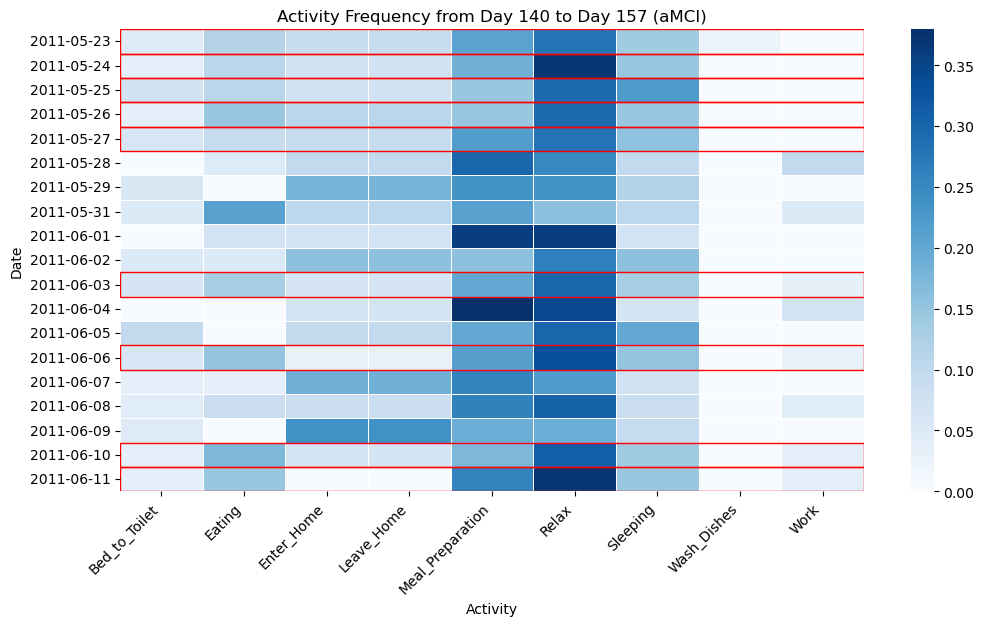

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'test_data' with columns 'Date' and 'Activity'
# Make sure 'Date' column is in datetime format

# Filter the test data for days 140 to 158
start_date = unique_dates[val_split_index + 139]
end_date = unique_dates[val_split_index + 157]
filtered_data = test_data[(test_data['Date'] >= start_date) & (test_data['Date'] <= end_date)]

# Create a pivot table for activity counts
activity_counts = filtered_data.pivot_table(index='Date', columns='Activity', aggfunc='size', fill_value=0)

# Normalize the activity counts for better visualization
activity_freq = activity_counts.div(activity_counts.sum(axis=1), axis=0)

# Set up the figure and axes
plt.figure(figsize=(12, 6))
ax = sns.heatmap(activity_freq, cmap="Blues", linewidths=0.5, linecolor='white')

# Customize labels and title
plt.xlabel('Activity')
plt.ylabel('Date')
plt.title('Activity Frequency from Day 140 to Day 157 (aMCI)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Get the list of anomalous dates
anomalous_dates = []
for date in test_data['Date'].unique():
    if date in random_sleep_days or \
       date in random_sleep_repeat_days or \
       date in random_sleep_housekeeping_days or \
       date in random_relax_days or \
       date in random_dementia_days:
        anomalous_dates.append(date)

# Convert anomalous dates to datetime objects
anomalous_dates = [pd.to_datetime(date) for date in anomalous_dates]

# Set the modified y-axis tick labels
ytick_labels = [date.strftime('%Y-%m-%d') for date in pd.to_datetime(activity_freq.index)]
ax.set_yticklabels(ytick_labels)

# Add black outline for rows with anomalous dates
for idx, date in enumerate(pd.to_datetime(activity_freq.index)):
    if date in anomalous_dates:
        ax.add_patch(plt.Rectangle((0, idx), activity_freq.shape[1], 1, fill=False, edgecolor='red'))

# Show the plot
plt.show()


## Encode activity labels into appropriate format for HMM

In [263]:
# Convert categorical activities to numerical labels
label_encoder = LabelEncoder()
train_data['Encoded_Activity'] = label_encoder.fit_transform(train_data['Activity'])
val_data['Encoded_Activity'] = label_encoder.transform(val_data['Activity'])
test_data['Encoded_Activity'] = label_encoder.transform(test_data['Activity'])

In [264]:
# Create a mapping between activity labels and their encoded values
activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print(activity_mapping)

{'Bed_to_Toilet': 0, 'Eating': 1, 'Enter_Home': 2, 'Housekeeping': 3, 'Leave_Home': 4, 'Meal_Preparation': 5, 'Relax': 6, 'Sleeping': 7, 'Wash_Dishes': 8, 'Work': 9}


In [265]:
print(train_data)

           Date          Activity  Encoded_Activity
0    2010-11-04          Sleeping                 7
1    2010-11-04     Bed_to_Toilet                 0
2    2010-11-04          Sleeping                 7
3    2010-11-04  Meal_Preparation                 5
4    2010-11-04             Relax                 6
5    2010-11-04      Housekeeping                 3
6    2010-11-04  Meal_Preparation                 5
7    2010-11-04            Eating                 1
8    2010-11-04       Wash_Dishes                 8
9    2010-11-04      Housekeeping                 3
10   2010-11-04        Leave_Home                 4
11   2010-11-04        Enter_Home                 2
12   2010-11-04        Leave_Home                 4
13   2010-11-04        Enter_Home                 2
14   2010-11-04             Relax                 6
15   2010-11-04  Meal_Preparation                 5
16   2010-11-04            Eating                 1
17   2010-11-04              Work                 9
18   2010-11

## Select the optimal number of hidden states

In [34]:
# Vary the number of hidden states and calculate log-likelihood for each one
aic = []
bic = []
lls = []
ns = range(2, 16)

for n in ns:
    best_ll = None
    best_model = None
    for rs in range(10): # 10 different random initialisations of hmm parameters - 
        # ensure that the initialization process is reproducible across different runs of your code.
        model = hmm.CategoricalHMM(n_components=n, n_iter = 10, random_state = rs)
        train = train_data['Encoded_Activity'].values.reshape(-1, 1)
        val = val_data['Encoded_Activity'].values.reshape(-1, 1)
        model.fit(train)
        log_likelihood = model.score(val) 
        if best_ll is None or log_likelihood > best_ll:
            best_ll = log_likelihood
            best_model = model
    aic.append(best_model.aic(val))
    bic.append(best_model.bic(val))
    lls.append(best_model.score(val))

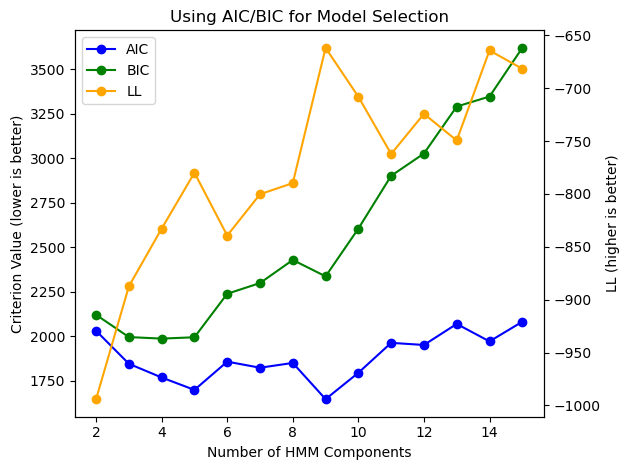

In [35]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

## Compare each day of test dataset to trained HMM model

### Fixing 'n_iter' to 100 leads to worse results and can't detect anomalous sequence compared to default

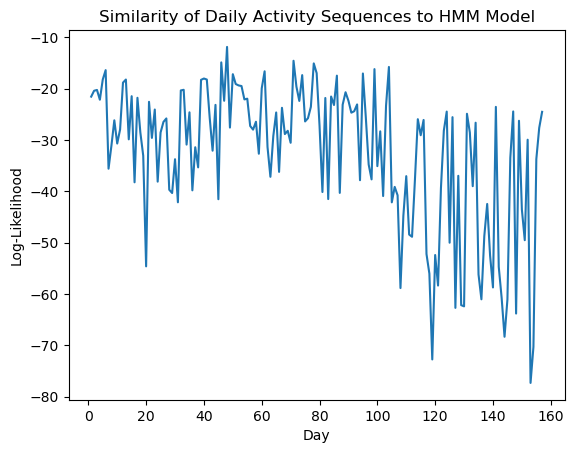

In [85]:
# Choose the number of hidden states based on AIC, BIC, and LL plot
num_states = 5

# Train the HMM model with the chosen number of hidden states

best_ll = None
best_model = None

for rs in range(10): 
    model = hmm.CategoricalHMM(n_components=num_states, n_iter = 5, random_state = rs)
    train_features = train_data['Encoded_Activity'].values.reshape(-1, 1)
    val_features = val_data['Encoded_Activity'].values.reshape(-1, 1)
    model.fit(train_features)
    log_likelihood = model.score(val_features) 
    if best_ll is None or log_likelihood > best_ll:
        best_ll = log_likelihood
        best_model = model
        
# # Modify the transition matrix to enforce left-to-right structure
# left_right_transmat = np.zeros((num_states, num_states))
# for i in range(num_states - 1):
#     left_right_transmat[i, i] = 0.5
#     left_right_transmat[i, i + 1] = 0.5
# left_right_transmat[num_states - 1, num_states - 1] = 1.0

# # Normalize the rows of the modified transition matrix
# left_right_transmat /= left_right_transmat.sum(axis=1, keepdims=True)

# # Update the model's transition matrix with the modified one
# best_model.transmat_ = left_right_transmat
        
# Calculate and plot log-likelihood of observation sequences for each day in test dataset
log_likelihoods = []
for date in test_data['Date'].unique():
    test_features = test_data.loc[test_data['Date'] == date, 'Encoded_Activity'].values.reshape(-1, 1)
    log_likelihood = best_model.score(test_features)
    log_likelihoods.append(log_likelihood)
    
plt.plot(range(1, len(test_data['Date'].unique()) + 1), log_likelihoods)
plt.xlabel('Day')
plt.ylabel('Log-Likelihood')
plt.title('Similarity of Daily Activity Sequences to HMM Model')
plt.show()

### Get threshold range from validation set

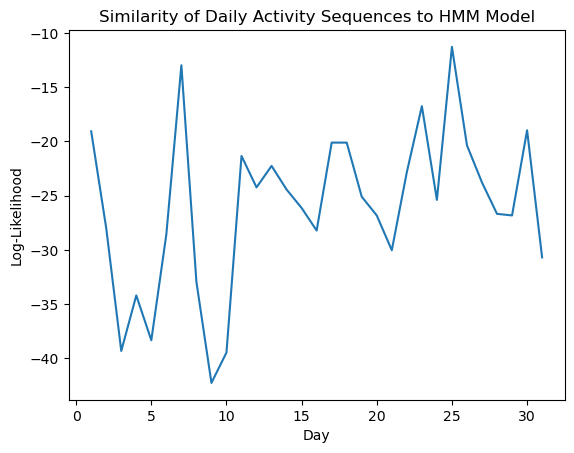

In [86]:
# Choose the number of hidden states based on AIC, BIC, and LL plot
num_states = 5

# Train the HMM model with the chosen number of hidden states

best_ll = None
best_model = None

for rs in range(10): 
    model = hmm.CategoricalHMM(n_components=num_states, n_iter = 5, random_state = rs)
    train_features = train_data['Encoded_Activity'].values.reshape(-1, 1)
    val_features = val_data['Encoded_Activity'].values.reshape(-1, 1)
    model.fit(train_features)
    log_likelihood = model.score(val_features) 
    if best_ll is None or log_likelihood > best_ll:
        best_ll = log_likelihood
        best_model = model
        
# Calculate and plot log-likelihood of observation sequences for each day in test dataset
val_log_likelihoods = []
for date in val_data['Date'].unique():
    val_features = val_data.loc[val_data['Date'] == date, 'Encoded_Activity'].values.reshape(-1, 1)
    log_likelihood = best_model.score(val_features)
    val_log_likelihoods.append(log_likelihood)
    
plt.plot(range(1, len(val_data['Date'].unique()) + 1), val_log_likelihoods)
plt.xlabel('Day')
plt.ylabel('Log-Likelihood')
plt.title('Similarity of Daily Activity Sequences to HMM Model')
plt.show()

### Optimal threshold selection

In [114]:
# Extract the true labels for anomalies in the test dataset
true_labels = []

for date in test_data['Date'].unique():
    if date in random_sleep_days or \
       date in random_sleep_repeat_days or \
       date in random_sleep_housekeeping_days or \
       date in random_relax_days or \
       date in random_dementia_days:
        true_labels.append(1)  # Anomaly introduced
    else:
        true_labels.append(0)  # Normal behavior

# Determine the minimum and maximum scores
min_score = min(val_log_likelihoods)
max_score = max(val_log_likelihoods)

# Linearly sample 1000 threshold choices
threshold_choices = np.linspace(min_score, max_score, num=1000)

# Initialize variables to store the best threshold and its corresponding F1 score
best_threshold = None
best_f1_score = None

# Iterate over the threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(log_likelihoods >= threshold, 0, 1)
    
    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels)
    
    # Update the best threshold and F1 score if necessary
    if best_f1_score is None or f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

# Print the best threshold and its corresponding F1 score
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: -40.1418645954707
Best F1 Score: 0.7792207792207793


In [199]:
anomalous_dates = []
for date in test_data['Date'].unique():
    if date in random_sleep_days or \
       date in random_sleep_repeat_days or \
       date in random_sleep_housekeeping_days or \
       date in random_relax_days or \
       date in random_dementia_days:
        anomalous_dates.append(date)
        
print(anomalous_dates)

['2011-03-25', '2011-03-26', '2011-03-28', '2011-03-29', '2011-03-30', '2011-04-01', '2011-04-02', '2011-04-04', '2011-04-06', '2011-04-08', '2011-04-16', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-04', '2011-05-05', '2011-05-09', '2011-05-11', '2011-05-13', '2011-05-14', '2011-05-19', '2011-05-20', '2011-05-21', '2011-05-24', '2011-05-26', '2011-05-27', '2011-05-28', '2011-05-29', '2011-06-02', '2011-06-05', '2011-06-07', '2011-06-08']


## Visualising the anomalous days

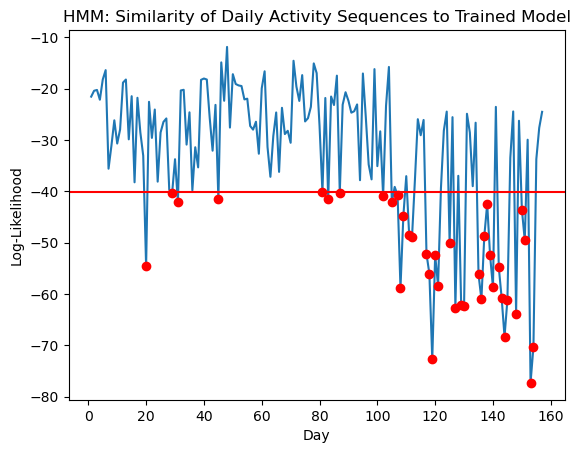

In [115]:
# Define the threshold as one standard deviations below the mean
# mean_ll = np.mean(log_likelihoods)
# std_ll = np.std(log_likelihoods)
# threshold = mean_ll - 0.8*std_ll

# Identify the anomalies by comparing the log-likelihoods to the threshold
anomalies = np.where(log_likelihoods < best_threshold)[0]

# Plot the log-likelihoods against the day
plt.plot(range(1, len(test_data['Date'].unique()) + 1), log_likelihoods)

# Plot the threshold line and color the anomalies
plt.axhline(y=best_threshold, color='r', linestyle='-')
for anomaly in anomalies:
    plt.plot(anomaly + 1, log_likelihoods[anomaly], 'ro')

plt.xlabel('Day')
plt.ylabel('Log-Likelihood')
plt.title('HMM: Similarity of Daily Activity Sequences to Trained Model')
plt.show()

In [116]:
print("Anomalous days detected:")
for anomaly in anomalies:
    print(test_data['Date'].unique()[anomaly])

Anomalous days detected:
2011-01-24
2011-02-02
2011-02-04
2011-02-18
2011-03-26
2011-03-28
2011-04-01
2011-04-16
2011-04-19
2011-04-21
2011-04-22
2011-04-23
2011-04-25
2011-04-26
2011-05-01
2011-05-02
2011-05-03
2011-05-04
2011-05-05
2011-05-09
2011-05-11
2011-05-13
2011-05-14
2011-05-19
2011-05-20
2011-05-21
2011-05-22
2011-05-23
2011-05-24
2011-05-26
2011-05-27
2011-05-28
2011-05-29
2011-06-02
2011-06-04
2011-06-05
2011-06-07
2011-06-08


In [117]:
# # Create a dictionary to map encoded activity values to activity names
# activity_mapping = dict(zip(label_encoder.transform(train_data['Activity']), train_data['Activity']))

# # Anomalous sequence for visualization
# anomalous_date = '2011-02-02'  # Specify date to visualise
# anomalous_sequence = test_data.loc[test_data['Date'] == anomalous_date, 'Encoded_Activity'].values

# # Map encoded activity values to activity names
# anomalous_activity_names = [activity_mapping[encoded_value] for encoded_value in anomalous_sequence]

# print("Anomalous day detected:", anomalous_date)
# print("Anomalous activity sequence:", anomalous_activity_names)

# # Create a custom activity sequence visualization with square boxes
# all_activity_names = list(activity_mapping.values())
# num_activities = len(all_activity_names)
# activity_matrix = np.zeros((num_activities, len(anomalous_activity_names)))  # Initialize a matrix of zeros

# for i, activity in enumerate(anomalous_activity_names):
#     if activity in all_activity_names:  # If the activity is present, mark the corresponding position as 1
#         activity_index = all_activity_names.index(activity)
#         activity_matrix[activity_index, i] = 1

# plt.figure(figsize=(10, 6))
# plt.imshow(activity_matrix, cmap='binary')
# plt.title('Anomalous Activity Sequence')
# plt.ylabel('Activity Name')
# plt.yticks(np.arange(num_activities), all_activity_names)  # Set y-axis labels to all possible activity names
# plt.xticks([])  # Remove x-axis labels
# plt.tight_layout()
# plt.show()

## ROC Curve

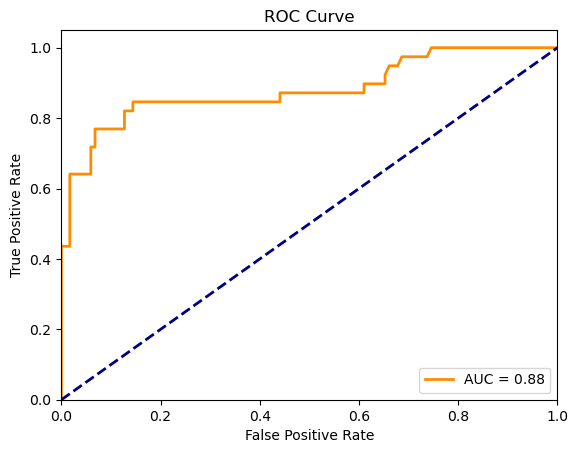

0.8812472837896567


In [118]:
# Linearly sample 100 threshold choices
threshold_choices = np.linspace(-100, 0, num=2000)

# Initialize arrays to store the true positive rate (TPR) and false positive rate (FPR)
tpr_scores = []
fpr_scores = []

# Iterate over threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(log_likelihoods >= threshold, 0, 1)
    
    # Calculate the true positive rate (TPR) and false positive rate (FPR)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Append TPR and FPR to arrays
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)

# Calculate the Area Under the Curve (AUC) using auc function
roc_auc = auc(fpr_scores, tpr_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_scores, tpr_scores, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)

## Confusion matrix shows high false positives

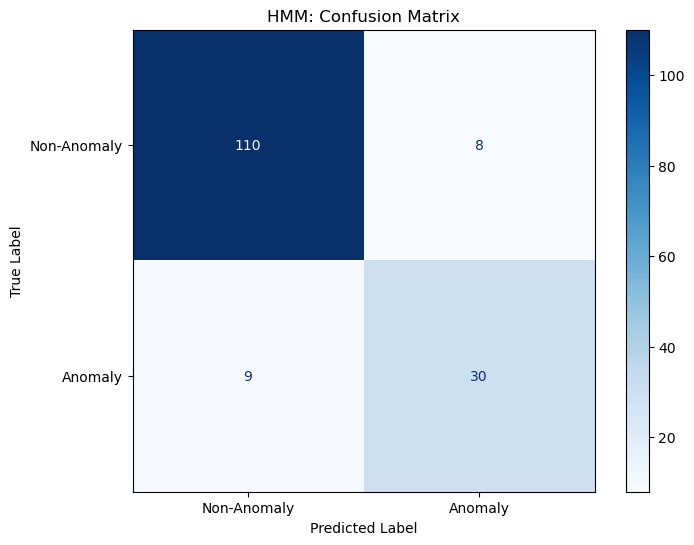

In [119]:
predicted_labels = np.where(log_likelihoods >= best_threshold, 0, 1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Non-Anomaly', 'Anomaly'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Customize the plot
plt.title('HMM: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

## Evaluation Scores

In [44]:
predicted_labels = np.where(log_likelihoods >= best_threshold, 0, 1)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# measure of all the correctly identified cases. It is most used when all the classes are equally important.
print('Accuracy:', accuracy) # (TP + TN)/Total = (53+48)/134

# measure of the correctly identified positive cases from all the predicted positive cases. 
# Thus, it is useful when the costs of False Positives is high.
print('Precision:', precision) # TP/(TP + FP) = 53/(53+30)

# measure of the correctly identified positive cases from all the actual positive cases. 
# It is important when the cost of False Negatives is high.
print('Recall', recall) # TP/(TP + FN) = 53/(53+3)

# harmonic mean of Precision and Recall and 
# Gives a better measure of the incorrectly classified cases than the Accuracy Metric.
print('F1 score', f1)

# Accuracy can be used when the class distribution is similar while 
# F1-score is a better metric when there are imbalanced classes as in the above case.

Accuracy: 0.89171974522293
Precision: 0.7894736842105263
Recall 0.7692307692307693
F1 score 0.7792207792207793


# LSTM

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        fc_output = self.fc(out)
        return fc_output

# Create the dictionary for activity encoding
activity_encoder = {
    0: 'Bed_to_Toilet',
    1: 'Eating',
    2: 'Enter_Home',
    3: 'Housekeeping',
    4: 'Leave_Home',
    5: 'Meal_Preparation',
    6: 'Relax',
    7: 'Sleeping',
    8: 'Wash_Dishes',
    9: 'Work',
    10: 'EoS'
}

# Convert train sequences to processed tensors
processed_train_sequences = []
for date, group in train_data.groupby('Date'):
    sequence = group['Encoded_Activity'].tolist()
    sequence.append(10)  # Add EoS symbol
    processed_train_sequences.extend(sequence)

# Segment sequences using sliding window
window_size = 5
train_segments = []
for i in range(0, len(processed_train_sequences) - window_size):
    window = processed_train_sequences[i : i + window_size]
    target_activity = processed_train_sequences[i + window_size]
    
    # Create a one-hot vector for the target
    target_one_hot = torch.zeros(len(activity_encoder))  # Create a zero-filled vector of length 11
    target_one_hot[target_activity] = 1  # Set the target activity index to 1
    
    train_segments.append((window, target_one_hot))
    
# Convert val sequences to processed tensors
processed_val_sequences = []
for date, group in val_data.groupby('Date'):
    sequence = group['Encoded_Activity'].tolist()
    sequence.append(10)  # Add EoS symbol
    processed_val_sequences.extend(sequence)

# Segment sequences using sliding window for validation data
val_segments = []
for i in range(0, len(processed_val_sequences) - window_size):
    window = processed_val_sequences[i : i + window_size]
    target_activity = processed_val_sequences[i + window_size]
    
    # Create a one-hot vector for the target
    target_one_hot = torch.zeros(len(activity_encoder))  # Create a zero-filled vector of length 11
    target_one_hot[target_activity] = 1  # Set the target activity index to 1
    
    val_segments.append((window, target_one_hot))

In [46]:
# Instantiate the LSTM model
input_size = 5
hidden_size = 128
num_layers = 4
output_size = len(activity_encoder)
num_epochs = 50
batch_size = 10
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()   # You can use other appropriate loss functions for sequences
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert train sequences to DataLoader
train_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in train_segments]
windows, targets = zip(*train_data_tensors)
targets = [target.view(1, -1) for target in targets]
train = TensorDataset(torch.stack(windows), torch.cat(targets))
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

# Convert val sequences to DataLoader
val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in val_segments]
val_windows, val_targets = zip(*val_data_tensors)
val_targets = [target.view(1, -1) for target in val_targets]
val_dataset = TensorDataset(torch.stack(val_windows), torch.cat(val_targets))
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Inside the training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()

        sequences, targets = batch
        sequences = sequences.unsqueeze(1).to(torch.float32)  # Add an extra dimension
        
        # Detach hidden states from previous iteration
        lstm_model.lstm.flatten_parameters()
        
        outputs = lstm_model(sequences)

        # Modify targets to contain class indices
        targets = torch.argmax(targets, dim=1)
        
        loss = criterion(outputs.view(-1, output_size), targets)  # Reshape the targets tensor
        loss.backward()
        optimizer.step()
        
     # Validation loop
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sequences, targets = batch
            sequences = sequences.unsqueeze(1).to(torch.float32)
            
            lstm_model.lstm.flatten_parameters()
            outputs = lstm_model(sequences)
            
            # Modify targets to contain class indices
            val_targets = torch.argmax(targets, dim=1)
            
            loss = criterion(outputs.view(-1, output_size), val_targets)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)  # Average validation loss
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

/var/folders/hy/3s7ydp6x6q318tvnp5t1_mr40000gn/T/ipykernel_64582/3087596017.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in train_segments]
/var/folders/hy/3s7ydp6x6q318tvnp5t1_mr40000gn/T/ipykernel_64582/3087596017.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in val_segments]


Epoch [1/50], Loss: 2.5005, Val Loss: 2.1018
Epoch [2/50], Loss: 2.5126, Val Loss: 2.0967
Epoch [3/50], Loss: 2.4808, Val Loss: 2.0979
Epoch [4/50], Loss: 2.4562, Val Loss: 2.0939
Epoch [5/50], Loss: 2.5296, Val Loss: 2.0301
Epoch [6/50], Loss: 2.6544, Val Loss: 2.0162
Epoch [7/50], Loss: 2.9381, Val Loss: 1.8594
Epoch [8/50], Loss: 2.5123, Val Loss: 1.5714
Epoch [9/50], Loss: 2.4006, Val Loss: 1.5306
Epoch [10/50], Loss: 2.2208, Val Loss: 1.3846
Epoch [11/50], Loss: 2.4149, Val Loss: 1.6790
Epoch [12/50], Loss: 2.1195, Val Loss: 1.2784
Epoch [13/50], Loss: 2.0969, Val Loss: 1.2538
Epoch [14/50], Loss: 2.0188, Val Loss: 1.2384
Epoch [15/50], Loss: 1.9285, Val Loss: 1.2322
Epoch [16/50], Loss: 1.9316, Val Loss: 1.1946
Epoch [17/50], Loss: 2.1129, Val Loss: 1.4761
Epoch [18/50], Loss: 2.0268, Val Loss: 1.2065
Epoch [19/50], Loss: 2.0226, Val Loss: 1.1804
Epoch [20/50], Loss: 1.9851, Val Loss: 1.1523
Epoch [21/50], Loss: 1.8770, Val Loss: 1.1442
Epoch [22/50], Loss: 1.7993, Val Loss: 1.14

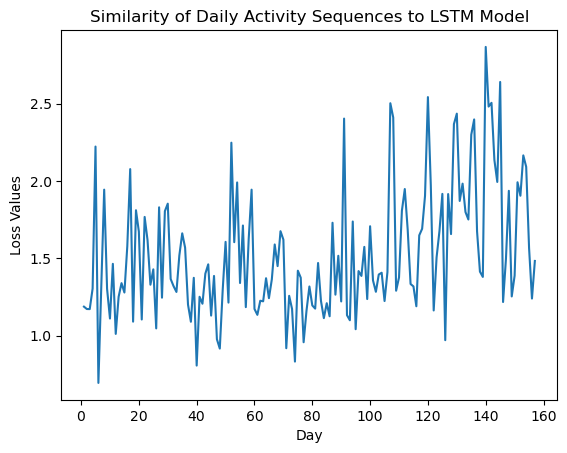

In [106]:
# Calculate error values for each day
test_error_values = []
window_size = 5
lstm_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for date, group in test_data.groupby('Date'):
        processed_test_sequences = []
        test_sequences = group['Encoded_Activity'].tolist()
        test_sequences.append(10)  # Add EoS symbol
        processed_test_sequences.extend(test_sequences)

        # Segment sequences using sliding window
        test_segments = []
        for i in range(0, len(processed_test_sequences) - window_size):
            window = processed_test_sequences[i : i + window_size]
            target = processed_test_sequences[i + window_size]
            test_segments.append((window, target))
        
        # Create DataLoader for test data
        test_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long))
                             for window, target in test_segments]

        windows, targets = zip(*test_data_tensors)

        test = TensorDataset(torch.stack(windows), torch.stack(targets))

        test_loader = DataLoader(dataset=test, batch_size=1, shuffle=False)

        # Calculate loss values for each sequence
        sequence_loss_values = []
        for batch in test_loader:
            sequences, target = batch
            sequences = sequences.unsqueeze(0).to(torch.float32)

            outputs = lstm_model(sequences)

            loss = criterion(outputs.view(-1, output_size), target)  # Use class index as target

            sequence_loss_values.append(loss.item())
            
        # Calculate the average sliding window error value for the day
        average_test_loss = sum(sequence_loss_values) / len(sequence_loss_values)
        test_error_values.append(average_test_loss)
        sequence_loss_values = []

# Plot average error values against days
plt.plot(range(1, len(test_data['Date'].unique()) + 1), test_error_values)
plt.xlabel('Day')
plt.ylabel('Loss Values')
plt.title('Similarity of Daily Activity Sequences to LSTM Model')
plt.show()

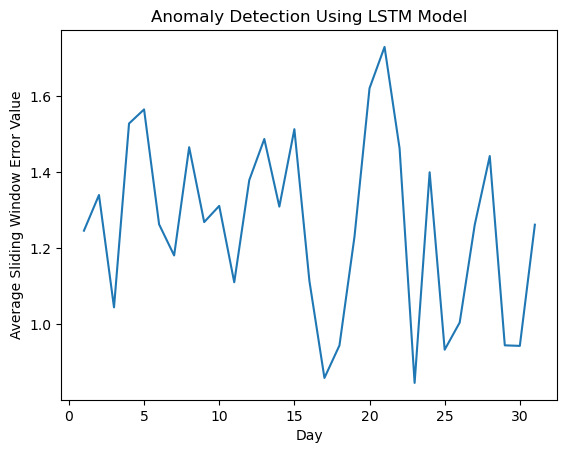

In [107]:
# Calculate error values for each day
val_error_values = []
window_size = 5
lstm_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for date, group in val_data.groupby('Date'):
        processed_val_sequences = []
        val_sequences = group['Encoded_Activity'].tolist()
        val_sequences.append(10)  # Add EoS symbol
        processed_val_sequences.extend(val_sequences)

        # Segment sequences using sliding window
        val_segments = []
        for i in range(0, len(processed_val_sequences) - window_size):
            window = processed_val_sequences[i : i + window_size]
            target = processed_val_sequences[i + window_size]
            val_segments.append((window, target))

        # Create DataLoader for val data
        val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long))
                             for window, target in val_segments]

        windows, targets = zip(*val_data_tensors)

        val = TensorDataset(torch.stack(windows), torch.stack(targets))

        val_loader = DataLoader(dataset=val, batch_size=1, shuffle=False)

        # Calculate loss values for each sequence
        sequence_loss_values = []
        for batch in val_loader:
            sequences, target = batch
            sequences = sequences.unsqueeze(0).to(torch.float32)

            outputs = lstm_model(sequences)

            loss = criterion(outputs.view(-1, output_size), target)  # Use class index as target

            sequence_loss_values.append(loss.item())

        # Calculate the average sliding window error value for the day
        average_val_loss = sum(sequence_loss_values) / len(sequence_loss_values)
        val_error_values.append(average_val_loss)

# Plot average error values against days
plt.plot(range(1, len(val_data['Date'].unique()) + 1), val_error_values)
plt.xlabel('Day')
plt.ylabel('Average Sliding Window Error Value')
plt.title('Anomaly Detection Using LSTM Model')
plt.show()

val_min = min(val_error_values)
val_max = max(val_error_values)

In [120]:
# Linearly sample 1000 threshold choices
threshold_choices = np.linspace(val_min, val_max, num=3000)

# Initialize variables to store the best threshold and its corresponding F1 score
best_threshold = None
best_f1_score = None

# Iterate over the threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(test_error_values <= threshold, 0, 1)
    
    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels)
    
    # Update the best threshold and F1 score if necessary
    if best_f1_score is None or f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

# Print the best threshold and its corresponding F1 score
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: 1.6726264637253965
Best F1 Score: 0.6136363636363635


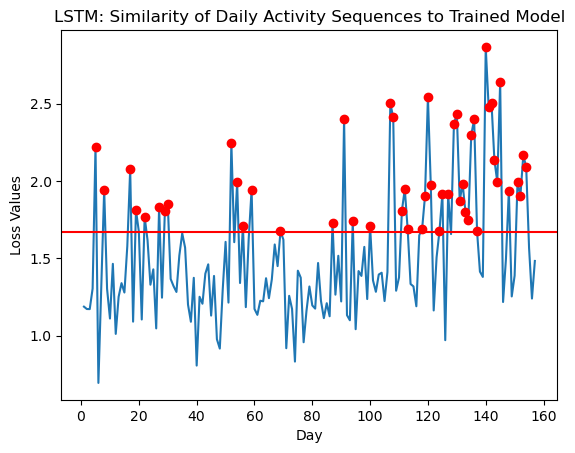

In [121]:
# Identify the anomalies by comparing the log-likelihoods to the threshold
anomalies = np.where(np.array(test_error_values) >= best_threshold)[0]

# Plot the log-likelihoods against the day
plt.plot(range(1, len(test_data['Date'].unique()) + 1), test_error_values)

# Plot the threshold line and color the anomalies
plt.axhline(y=best_threshold, color='r', linestyle='-')
for anomaly in anomalies:
    plt.plot(anomaly + 1, test_error_values[anomaly], 'ro')

plt.xlabel('Day')
plt.ylabel('Loss Values')
plt.title('LSTM: Similarity of Daily Activity Sequences to Trained Model')
plt.show()

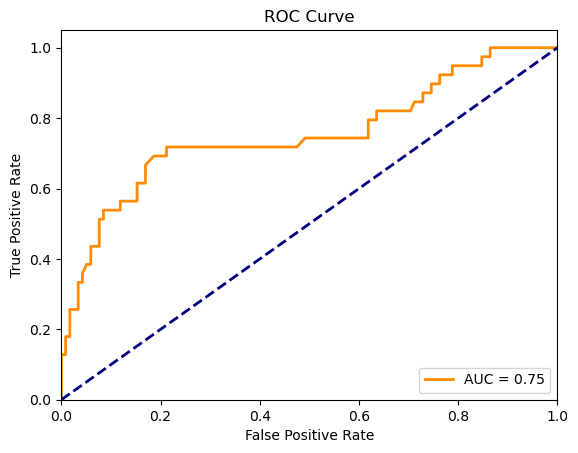

0.752716210343329


In [122]:
# Linearly sample 100 threshold choices
threshold_choices = np.linspace(0, 8, num=3000)

# Initialize arrays to store the true positive rate (TPR) and false positive rate (FPR)
tpr_scores = []
fpr_scores = []

# Iterate over threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(test_error_values <= threshold, 0, 1)
    
    # Calculate the true positive rate (TPR) and false positive rate (FPR)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Append TPR and FPR to arrays
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)

# Calculate the Area Under the Curve (AUC) using auc function
roc_auc = auc(fpr_scores, tpr_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_scores, tpr_scores, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)

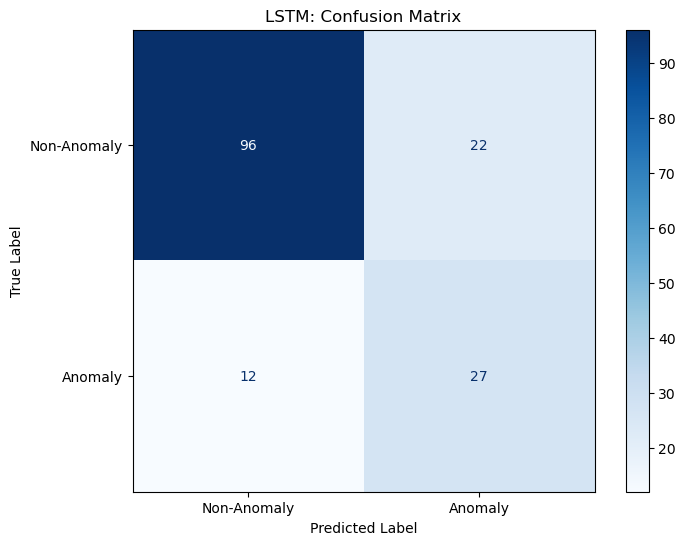

In [123]:
predicted_labels = np.where(test_error_values <= best_threshold, 0, 1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Non-Anomaly', 'Anomaly'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Customize the plot
plt.title('LSTM: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [112]:
predicted_labels = np.where(test_error_values <= best_threshold, 0, 1)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# measure of all the correctly identified cases. It is most used when all the classes are equally important.
print('Accuracy:', accuracy) # (TP + TN)/Total = (53+48)/134

# measure of the correctly identified positive cases from all the predicted positive cases. 
# Thus, it is useful when the costs of False Positives is high.
print('Precision:', precision) # TP/(TP + FP) = 53/(53+30)

# measure of the correctly identified positive cases from all the actual positive cases. 
# It is important when the cost of False Negatives is high.
print('Recall', recall) # TP/(TP + FN) = 53/(53+3)

# harmonic mean of Precision and Recall and 
# Gives a better measure of the incorrectly classified cases than the Accuracy Metric.
print('F1 score', f1)

# Accuracy can be used when the class distribution is similar while 
# F1-score is a better metric when there are imbalanced classes as in the above case.

Accuracy: 0.7834394904458599
Precision: 0.5510204081632653
Recall 0.6923076923076923
F1 score 0.6136363636363635


# Autoencoder

## Building the AE

In [54]:
# Group the train_data by 'Date' and calculate the average sequence length for each day
average_sequence_lengths = train_data.groupby('Date')['Activity'].apply(lambda x: len(x)).mean()

print("Average sequence lengths:")
print(average_sequence_lengths)

Average sequence lengths:
20.870967741935484


In [168]:
# Convert 'Activity' labels to indices
activity_encoder = LabelEncoder()
activity_indices = torch.tensor(activity_encoder.fit_transform(train_data['Activity']), dtype=torch.long)

# Create DataLoader for training
batch_size = 20
train_loader = DataLoader(dataset=TensorDataset(activity_indices), batch_size=batch_size, shuffle=False, drop_last=True)

# Define the sequence-to-sequence autoencoder
class SequenceAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SequenceAutoencoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(1, 0)
        encoded, _ = self.encoder(embedded)
        decoded, _ = self.decoder(encoded)
        reconstructed = self.output_layer(decoded)
        reconstructed = self.relu(reconstructed) 
        return reconstructed

# Instantiate the sequence autoencoder
input_size = len(activity_encoder.classes_)
hidden_size = 32 # You can adjust this based on your needs
sequence_autoencoder = SequenceAutoencoder(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for sequence prediction
optimizer = optim.Adam(sequence_autoencoder.parameters(), lr=0.001)

# Train the sequence autoencoder
num_epochs = 200
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = batch[0]
        optimizer.zero_grad()
        
        # Pad or truncate the batch to match the hidden_size
        if batch.size(0) < hidden_size:
            padded_sequence = torch.cat([batch, torch.zeros(hidden_size - batch.size(0), dtype=torch.long)])
        elif batch.size(0) > hidden_size:
            padded_sequence = batch[:hidden_size]
        else:
            padded_sequence = batch
        
        # Corrected inputs
        outputs = sequence_autoencoder(padded_sequence)
        
        # Calculate loss and reshape predictions and targets
        loss = criterion(outputs.view(-1, input_size), padded_sequence.view(-1))
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained sequence autoencoder
torch.save(sequence_autoencoder.state_dict(), 'sequence_autoencoder.pth')

Epoch [1/200], Loss: 2.3031
Epoch [2/200], Loss: 2.2982
Epoch [3/200], Loss: 2.2705
Epoch [4/200], Loss: 1.6220
Epoch [5/200], Loss: 1.4116
Epoch [6/200], Loss: 1.3285
Epoch [7/200], Loss: 1.2938
Epoch [8/200], Loss: 1.2655
Epoch [9/200], Loss: 1.2287
Epoch [10/200], Loss: 1.1918
Epoch [11/200], Loss: 1.1401
Epoch [12/200], Loss: 1.0979
Epoch [13/200], Loss: 1.0617
Epoch [14/200], Loss: 1.0234
Epoch [15/200], Loss: 0.9924
Epoch [16/200], Loss: 0.9423
Epoch [17/200], Loss: 0.9053
Epoch [18/200], Loss: 0.8672
Epoch [19/200], Loss: 0.8322
Epoch [20/200], Loss: 0.8161
Epoch [21/200], Loss: 0.7940
Epoch [22/200], Loss: 0.7637
Epoch [23/200], Loss: 0.7304
Epoch [24/200], Loss: 0.6893
Epoch [25/200], Loss: 0.6768
Epoch [26/200], Loss: 0.6300
Epoch [27/200], Loss: 0.5843
Epoch [28/200], Loss: 0.5877
Epoch [29/200], Loss: 0.5754
Epoch [30/200], Loss: 0.5695
Epoch [31/200], Loss: 0.5163
Epoch [32/200], Loss: 0.4702
Epoch [33/200], Loss: 0.4384
Epoch [34/200], Loss: 0.4139
Epoch [35/200], Loss: 0

In [169]:
print(activity_indices)

tensor([7, 0, 7, 5, 6, 3, 5, 1, 8, 3, 4, 2, 4, 2, 6, 5, 1, 9, 6, 5, 6, 5, 6, 1,
        8, 9, 7, 0, 7, 5, 9, 6, 3, 4, 2, 4, 2, 4, 2, 9, 6, 4, 2, 4, 2, 5, 1, 8,
        4, 2, 9, 7, 0, 7, 5, 1, 8, 9, 3, 6, 3, 5, 1, 8, 1, 4, 2, 4, 2, 4, 2, 6,
        9, 7, 0, 7, 0, 7, 0, 7, 5, 1, 6, 9, 6, 5, 1, 5, 1, 6, 1, 6, 3, 9, 5, 1,
        6, 1, 5, 1, 6, 9, 6, 1, 5, 1, 8, 6, 9, 1, 6, 7, 0, 7, 5, 6, 5, 6, 5, 6,
        1, 4, 2, 4, 2, 4, 2, 5, 1, 8, 6, 3, 4, 2, 9, 4, 2, 9, 6, 5, 1, 6, 7, 0,
        7, 0, 7, 5, 6, 5, 3, 6, 3, 4, 2, 4, 2, 1, 5, 1, 6, 4, 2, 6, 5, 1, 5, 1,
        8, 9, 6, 7, 5, 6, 5, 6, 5, 1, 4, 2, 5, 1, 5, 1, 6, 7, 0, 7, 5, 6, 9, 5,
        1, 9, 4, 2, 5, 1, 6, 4, 2, 6, 5, 6, 5, 6, 5, 9, 5, 6, 5, 1, 7, 0, 7, 5,
        6, 5, 6, 5, 1, 9, 4, 2, 4, 2, 4, 2, 5, 1, 4, 2, 9, 3, 9, 5, 4, 2, 5, 1,
        6, 7, 0, 7, 5, 6, 5, 1, 6, 9, 5, 1, 8, 6, 7, 5, 1, 8, 6, 4, 2, 6, 5, 6,
        5, 6, 5, 6, 5, 6, 7, 0, 7, 5, 6, 9, 3, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
        2, 4, 2, 5, 1, 8, 6, 4, 2, 5, 1,

## Compare each day of test dataset to trained AE model

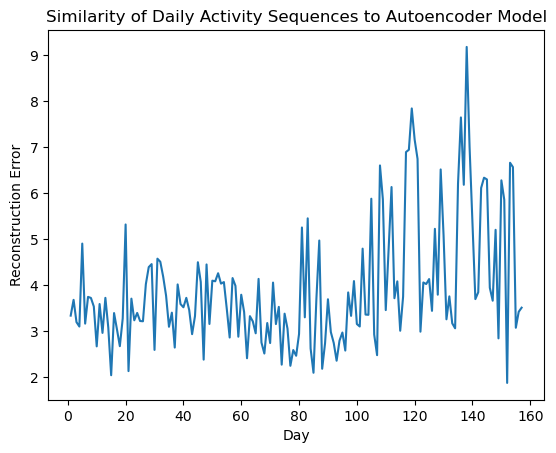

In [170]:
# Load the trained sequence autoencoder
sequence_autoencoder.load_state_dict(torch.load('sequence_autoencoder.pth'))
sequence_autoencoder.eval()

# Convert 'Activity' labels to indices for test data
test_indices = activity_encoder.transform(test_data['Activity'])

# Dictionary to store activity sequences for each day
day_sequences = {}

# Populate the day_sequences dictionary
for date, activity_index in zip(test_data['Date'], test_indices):
    if date not in day_sequences:
        day_sequences[date] = []
    day_sequences[date].append(activity_index)

# Perform anomaly detection
reconstruction_errors = []
with torch.no_grad():
    for date, sequence in day_sequences.items():
        # Pad or truncate the sequence to match the hidden_size
        if len(sequence) < hidden_size:
            padded_sequence = sequence + [0] * (hidden_size - len(sequence))
        else:
            padded_sequence = sequence[:hidden_size]
        padded_sequence_tensor = torch.tensor(padded_sequence, dtype=torch.long)

        # Pass through the autoencoder
        reconstructed_output = sequence_autoencoder(padded_sequence_tensor)

        # Calculate reconstruction loss for each time step
        loss = nn.functional.cross_entropy(reconstructed_output, padded_sequence_tensor)
        
        # Store the average loss as the reconstruction error
        reconstruction_errors.append(loss.item())

plt.plot(range(1, len(test_data['Date'].unique()) + 1), reconstruction_errors)
plt.xlabel('Day')
plt.ylabel('Reconstruction Error')
plt.title('Similarity of Daily Activity Sequences to Autoencoder Model')
plt.show()

## Get min and max 'normal' range from Validation set

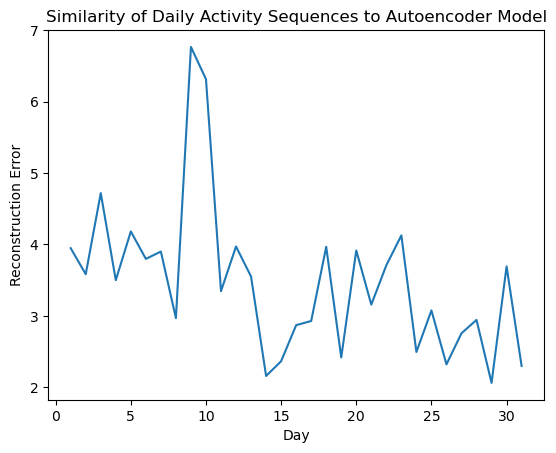

In [171]:
# Convert 'Activity' labels to indices for val data
val_indices = activity_encoder.transform(val_data['Activity'])

# Dictionary to store activity sequences for each day
val_day_sequences = {}

# Populate the day_sequences dictionary
for date, activity_index in zip(val_data['Date'], val_indices):
    if date not in val_day_sequences:
        val_day_sequences[date] = []
    val_day_sequences[date].append(activity_index)

# Perform anomaly detection
val_reconstruction_errors = []
with torch.no_grad():
    for date, sequence in val_day_sequences.items():
        # Pad or truncate the sequence to match the hidden_size
        if len(sequence) < hidden_size:
            padded_sequence = sequence + [0] * (hidden_size - len(sequence))
        else:
            padded_sequence = sequence[:hidden_size]
        padded_sequence_tensor = torch.tensor(padded_sequence, dtype=torch.long)

        # Pass through the autoencoder
        reconstructed_output = sequence_autoencoder(padded_sequence_tensor)

        # Calculate reconstruction loss for each time step
        loss = nn.functional.cross_entropy(reconstructed_output, padded_sequence_tensor)
        
        # Store the average loss as the reconstruction error
        val_reconstruction_errors.append(loss.item())

plt.plot(range(1, len(val_data['Date'].unique()) + 1), val_reconstruction_errors)
plt.xlabel('Day')
plt.ylabel('Reconstruction Error')
plt.title('Similarity of Daily Activity Sequences to Autoencoder Model')
plt.show()

val_min = min(val_reconstruction_errors)
val_max = max(val_reconstruction_errors)

## Optimal threshold selection

In [172]:
# Linearly sample 1000 threshold choices
threshold_choices = np.linspace(val_min, val_max, num=3000)

# Initialize variables to store the best threshold and its corresponding F1 score
best_threshold = None
best_f1_score = None

# Iterate over the threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(reconstruction_errors <= threshold, 0, 1)
    
    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels)
    
    # Update the best threshold and F1 score if necessary
    if best_f1_score is None or f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

# Print the best threshold and its corresponding F1 score
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: 4.5742759520151335
Best F1 Score: 0.7500000000000001


## Anomaly Detection

In [173]:
# anomaly_dates = []
# reconstruction_errors = []
# with torch.no_grad():
#     for date, sequence in day_sequences.items():
#         # Pad or truncate the sequence to match the hidden_size
#         if len(sequence) < hidden_size:
#             padded_sequence = sequence + [0] * (hidden_size - len(sequence))
#         else:
#             padded_sequence = sequence[:hidden_size]
#         padded_sequence_tensor = torch.tensor(padded_sequence, dtype=torch.long)

#         # Pass through the autoencoder
#         reconstructed_output = sequence_autoencoder(padded_sequence_tensor)

#         # Calculate reconstruction loss for each time step
#         loss = nn.functional.cross_entropy(reconstructed_output, padded_sequence_tensor)

#         # Average loss over the sequence length
#         avg_loss = torch.mean(loss)
        
#         # Store the average loss as the reconstruction error
#         reconstruction_errors.append(avg_loss.item())

#         # Compare loss to threshold for anomaly detection
#         if avg_loss > best_threshold:
#             anomaly_dates.append(date)

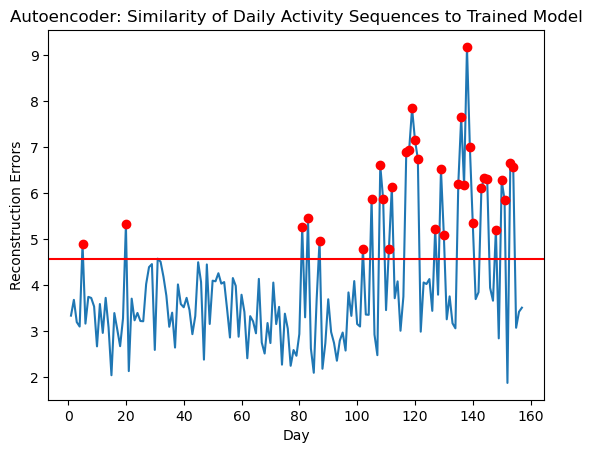

In [174]:
# Identify the anomalies by comparing the log-likelihoods to the threshold
anomalies = np.where(np.array(reconstruction_errors) >= best_threshold)[0]

# Plot the log-likelihoods against the day
plt.plot(range(1, len(test_data['Date'].unique()) + 1), reconstruction_errors)

# Plot the threshold line and color the anomalies
plt.axhline(y=best_threshold, color='r', linestyle='-')
for anomaly in anomalies:
    plt.plot(anomaly + 1, reconstruction_errors[anomaly], 'ro')

plt.xlabel('Day')
plt.ylabel('Reconstruction Errors')
plt.title('Autoencoder: Similarity of Daily Activity Sequences to Trained Model')
plt.show()


In [175]:
print("Anomalous days detected:")
for anomaly in anomalies:
    print(test_data['Date'].unique()[anomaly])

Anomalous days detected:
2011-01-09
2011-01-24
2011-03-26
2011-03-28
2011-04-01
2011-04-16
2011-04-19
2011-04-22
2011-04-23
2011-04-25
2011-04-26
2011-05-01
2011-05-02
2011-05-03
2011-05-04
2011-05-05
2011-05-11
2011-05-13
2011-05-14
2011-05-19
2011-05-20
2011-05-21
2011-05-22
2011-05-23
2011-05-24
2011-05-27
2011-05-28
2011-05-29
2011-06-02
2011-06-04
2011-06-05
2011-06-07
2011-06-08


## ROC Curve

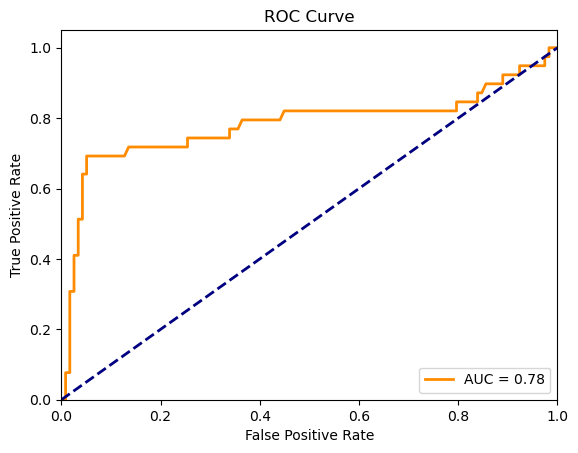

0.7816166883963493


In [176]:
# Linearly sample 100 threshold choices
threshold_choices = np.linspace(0, 15, num=3000)

# Initialize arrays to store the true positive rate (TPR) and false positive rate (FPR)
tpr_scores = []
fpr_scores = []

# Iterate over threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(reconstruction_errors <= threshold, 0, 1)
    
    # Calculate the true positive rate (TPR) and false positive rate (FPR)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Append TPR and FPR to arrays
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)

# Calculate the Area Under the Curve (AUC) using auc function
roc_auc = auc(fpr_scores, tpr_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_scores, tpr_scores, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)

## Confusion Matrix

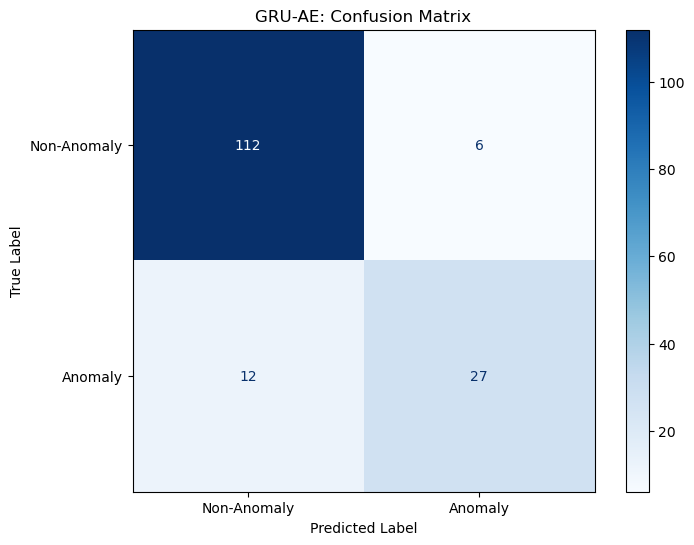

In [266]:
predicted_labels = np.where(reconstruction_errors <= best_threshold, 0, 1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Non-Anomaly', 'Anomaly'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Customize the plot
plt.title('GRU-AE: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

## Evaluation Metrics

In [178]:
## predicted_labels = np.where(reconstruction_errors <= best_threshold, 0, 1)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# measure of all the correctly identified cases. It is most used when all the classes are equally important.
print('Accuracy:', accuracy) # (TP + TN)/Total = (53+48)/134

# measure of the correctly identified positive cases from all the predicted positive cases. 
# Thus, it is useful when the costs of False Positives is high.
print('Precision:', precision) # TP/(TP + FP) = 53/(53+30)

# measure of the correctly identified positive cases from all the actual positive cases. 
# It is important when the cost of False Negatives is high.
print('Recall', recall) # TP/(TP + FN) = 53/(53+3)

# harmonic mean of Precision and Recall and 
# Gives a better measure of the incorrectly classified cases than the Accuracy Metric.
print('F1 score', f1)

# Accuracy can be used when the class distribution is similar while 
# F1-score is a better metric when there are imbalanced classes as in the above case.

Accuracy: 0.8853503184713376
Precision: 0.8181818181818182
Recall 0.6923076923076923
F1 score 0.7500000000000001


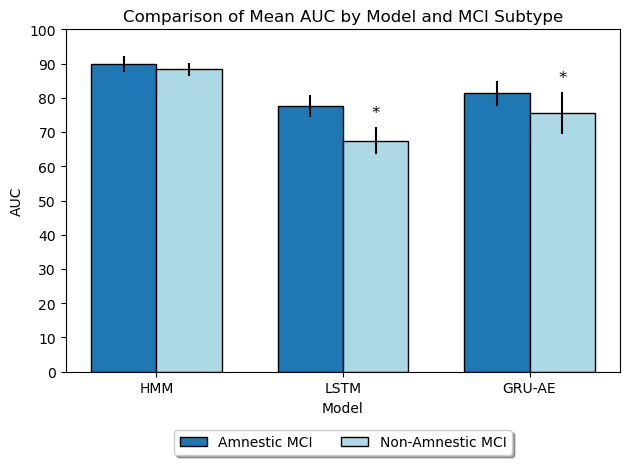

In [319]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar chart
models = ['HMM', 'LSTM', 'GRU-AE']
datasets = ['Amnestic MCI', 'Non-Amnestic MCI']

# AUC mean and std deviation results for Amnestic MCI and Non-Amnestic MCI
amnestic_auc_mean = [89.83, 77.54, 81.30]
amnestic_auc_std = [2.33, 3.19, 3.75]

non_amnestic_auc_mean = [88.32, 67.48, 75.64]
non_amnestic_auc_std = [1.84, 3.96, 6.19]

# Bar positions
bar_width = 0.35
index = np.arange(len(models))

# Create the bar chart
fig, ax = plt.subplots()
amnestic_bars = ax.bar(index, amnestic_auc_mean, bar_width, yerr=amnestic_auc_std, label='Amnestic MCI', color='tab:blue', edgecolor='black')
non_amnestic_bars = ax.bar(index + bar_width, non_amnestic_auc_mean, bar_width, yerr=non_amnestic_auc_std, label='Non-Amnestic MCI', color='lightblue', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('AUC')
ax.set_title('Comparison of Mean AUC by Model and MCI Subtype')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Set y-axis tick positions in units of 10 from 0 to 100
ax.set_yticks(np.arange(0, 101, 10))

# Move the legend outside the axes area to prevent overlap
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# Add asterisks above LSTM and GRU-AE bars in Non-Amnestic MCI
for i, bar in enumerate(non_amnestic_bars):
    if models[i] in ['LSTM', 'GRU-AE']:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + non_amnestic_auc_std[i] + 2, '*', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


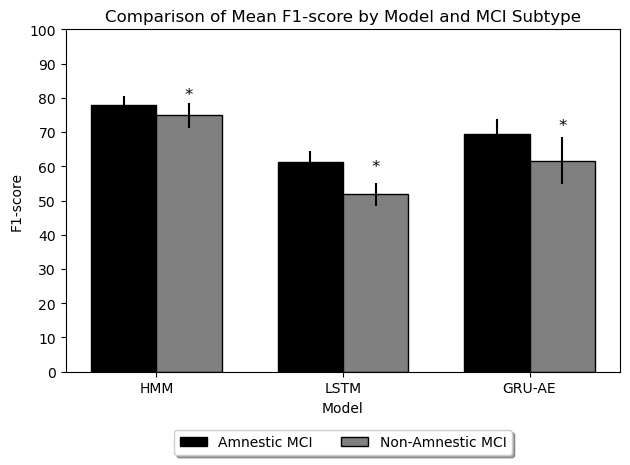

In [322]:
# Data for the bar chart
models = ['HMM', 'LSTM', 'GRU-AE']
datasets = ['Amnestic MCI', 'Non-Amnestic MCI']

# F1-score mean and std deviation results for Amnestic MCI and Non-Amnestic MCI
amnestic_f1_mean = [78.05, 61.39, 69.35]
amnestic_f1_std = [2.54, 3.03, 4.39]

non_amnestic_f1_mean = [74.92, 51.82, 61.61]
non_amnestic_f1_std = [3.64, 3.44, 6.92]

# Bar positions
bar_width = 0.35
index = np.arange(len(models))

# Create the bar chart
fig, ax = plt.subplots()
amnestic_bars = ax.bar(index, amnestic_f1_mean, bar_width, yerr=amnestic_f1_std, label='Amnestic MCI', color='black', edgecolor='black')
non_amnestic_bars = ax.bar(index + bar_width, non_amnestic_f1_mean, bar_width, yerr=non_amnestic_f1_std, label='Non-Amnestic MCI', color='grey', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('F1-score')
ax.set_title('Comparison of Mean F1-score by Model and MCI Subtype')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Set y-axis tick positions in units of 10 from 0 to 100
ax.set_yticks(np.arange(0, 101, 10))

# Move the legend outside the axes area to prevent overlap
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# Add asterisks above LSTM and GRU-AE bars in Non-Amnestic MCI
for i, bar in enumerate(non_amnestic_bars):
    if models[i] in ['HMM','LSTM', 'GRU-AE']:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + non_amnestic_auc_std[i] + 2, '*', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

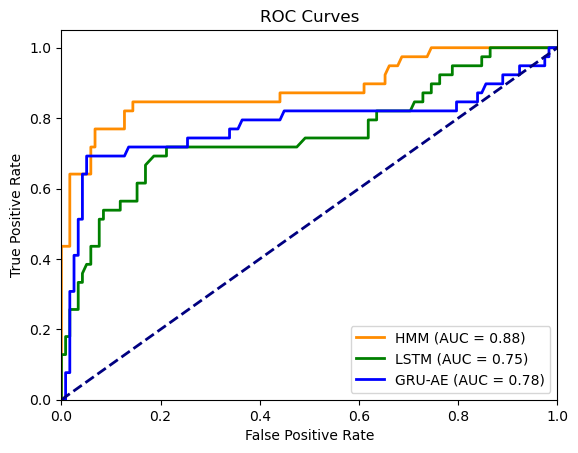

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, confusion_matrix

# Linearly sample threshold choices
threshold_choices_1 = np.linspace(-100, 0, num=2000)
threshold_choices_2 = np.linspace(0, 8, num=3000)
threshold_choices_3 = np.linspace(0, 15, num=3000)

# Initialize arrays to store TPR and FPR scores for each curve
tpr_scores_1 = []
fpr_scores_1 = []
tpr_scores_2 = []
fpr_scores_2 = []
tpr_scores_3 = []
fpr_scores_3 = []

# Function to calculate TPR and FPR scores
def calculate_scores(threshold_choices, error_values, greater_than_equal=True):
    tpr_scores = []
    fpr_scores = []
    for threshold in threshold_choices:
        if greater_than_equal:
            predicted_labels = np.where(error_values <= threshold, 0, 1)
        else:
            predicted_labels = np.where(error_values >= threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_scores.append(tpr)
        fpr_scores.append(fpr)
    return tpr_scores, fpr_scores

# Calculate scores for each curve
tpr_scores_1, fpr_scores_1 = calculate_scores(threshold_choices_1, log_likelihoods, greater_than_equal=False)
tpr_scores_2, fpr_scores_2 = calculate_scores(threshold_choices_2, test_error_values)
tpr_scores_3, fpr_scores_3 = calculate_scores(threshold_choices_3, reconstruction_errors)

# Calculate AUC for each curve
roc_auc_1 = auc(fpr_scores_1, tpr_scores_1)
roc_auc_2 = auc(fpr_scores_2, tpr_scores_2)
roc_auc_3 = auc(fpr_scores_3, tpr_scores_3)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr_scores_1, tpr_scores_1, color='darkorange', lw=2, label='HMM (AUC = %0.2f)' % roc_auc_1)
plt.plot(fpr_scores_2, tpr_scores_2, color='green', lw=2, label='LSTM (AUC = %0.2f)' % roc_auc_2)
plt.plot(fpr_scores_3, tpr_scores_3, color='blue', lw=2, label='GRU-AE (AUC = %0.2f)' % roc_auc_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


## aMCI ANOVA

In [310]:
import pandas as pd
from scipy.stats import f_oneway

# Create a DataFrame with your data
data = {
    'Model': ['HMM'] * 10 + ['LSTM'] * 10 + ['Autoencoder'] * 10,
    'AUC': [
        90.34, 85.33, 92.20, 88.55, 91.74, 93.06, 89.65, 88.24, 91.08, 88.12,
        78.51, 71.84, 83.84, 79.00, 78.47, 77.81, 77.76, 78.42, 74.45, 75.27,
        86.11, 82.61, 86.65, 75.81, 80.60, 84.17, 78.03, 78.20, 82.90, 77.93,
    ],
    'F1-score': [
        78.95, 75.76, 80.00, 75.68, 77.33, 82.67, 73.97, 78.26, 80.00, 77.92,
        60.87, 54.76, 65.31, 64.94, 63.16, 61.36, 59.09, 62.50, 60.54, 61.36,
        70.13, 68.57, 73.97, 66.67, 73.17, 75.00, 63.89, 62.50, 72.97, 66.67,
    ],
    'Precision': [
        81.08, 92.59, 83.33, 80.00, 80.56, 86.11, 79.41, 90.00, 83.33, 78.95,
        52.83, 51.11, 54.24, 65.79, 64.86, 55.10, 53.06, 60.98, 62.16, 55.10,
        71.05, 77.42, 79.41, 69.44, 69.77, 81.82, 69.70, 60.98, 77.14, 72.73,
    ],
    'Recall': [
        76.92, 64.10, 76.92, 71.79, 74.36, 79.48, 69.23, 69.23, 76.92, 76.92,
        71.79, 58.97, 82.05, 64.10, 61.54, 69.23, 66.67, 64.10, 58.97, 69.23,
        69.23, 61.54, 69.23, 64.10, 76.92, 69.23, 58.97, 64.10, 69.23, 61.54,
    ],
    'Accuracy': [
        89.81, 89.81, 90.45, 88.54, 89.17, 91.72, 87.90, 90.45, 90.45, 89.17,
        77.07, 75.80, 78.34, 82.80, 82.17, 78.34, 77.07, 80.89, 80.89, 78.34,
        85.35, 85.98, 87.90, 84.08, 85.99, 88.54, 83.44, 80.89, 87.26, 84.71,
    ]
}

df = pd.DataFrame(data)

# Separate the data for each model
df_hmm = df[df['Model'] == 'HMM']
df_lstm = df[df['Model'] == 'LSTM']
df_autoencoder = df[df['Model'] == 'Autoencoder']

# Metrics to loop through
metrics = ['AUC', 'F1-score', 'Precision', 'Recall', 'Accuracy']

# Perform ANOVA for each metric separately for aMCI vs. naMCI
for metric in metrics:
    f_statistic, p_value = f_oneway(
        df_hmm[metric], df_lstm[metric], df_autoencoder[metric]
    )
    print(f"ANOVA for {metric} - F-statistic:", f_statistic, "p-value:", p_value)


ANOVA for AUC - F-statistic: 40.0989517533453 p-value: 8.239405484167904e-09
ANOVA for F1-score - F-statistic: 59.79712848648734 p-value: 1.2045696107888893e-10
ANOVA for Precision - F-statistic: 58.11384017162307 p-value: 1.6483403076025702e-10
ANOVA for Recall - F-statistic: 4.971510863320412 p-value: 0.014511864309991032
ANOVA for Accuracy - F-statistic: 70.72688309813228 p-value: 1.844679947150402e-11


In [311]:
# Perform Tukey's HSD test for AUC
tukey_auc = pairwise_tukeyhsd(endog=df['AUC'], groups=df['Model'], alpha=0.05)

# Perform Tukey's HSD test for F1-score
tukey_f1 = pairwise_tukeyhsd(endog=df['F1-score'], groups=df['Model'], alpha=0.05)

tukey_precision = pairwise_tukeyhsd(endog=df['Precision'], groups=df['Model'], alpha=0.05)
tukey_recall = pairwise_tukeyhsd(endog=df['Recall'], groups=df['Model'], alpha=0.05)
tukey_accuracy = pairwise_tukeyhsd(endog=df['Accuracy'], groups=df['Model'], alpha=0.05)

# Print the results
print("Tukey's HSD Test for AUC:")
print(tukey_auc)
print("\nTukey's HSD Test for F1-score:")
print(tukey_f1)
print("Tukey's HSD Test for Precision:")
print(tukey_precision)
print("\nTukey's HSD Test for Recall:")
print(tukey_recall)
print("Tukey's HSD Test for Accuracy:")
print(tukey_accuracy)


Tukey's HSD Test for AUC:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1   group2 meandiff p-adj   lower  upper  reject
--------------------------------------------------------
Autoencoder    HMM     8.53    0.0   5.042 12.018   True
Autoencoder   LSTM   -3.764 0.0325  -7.252 -0.276   True
        HMM   LSTM  -12.294    0.0 -15.782 -8.806   True
--------------------------------------------------------

Tukey's HSD Test for F1-score:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1   group2 meandiff p-adj  lower    upper   reject
----------------------------------------------------------
Autoencoder    HMM      8.7   0.0   4.9204  12.4796   True
Autoencoder   LSTM   -7.965   0.0 -11.7446  -4.1854   True
        HMM   LSTM  -16.665   0.0 -20.4446 -12.8854   True
----------------------------------------------------------
Tukey's HSD Test for Precision:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1   group2 meandiff p-adj   lo

## naMCI ANOVA

In [312]:
# Define your data for AUC, F1-score, Precision, Recall, and Accuracy in the naMCI group
naMCI_data = {
    'Model': ['HMM'] * 10 + ['LSTM'] * 10 + ['Autoencoder'] * 10,
    'AUC': [
        86.71, 88.76, 87.71, 87.34, 90.24, 89.17, 91.29, 88.90, 88.36, 84.75,
        64.45, 63.71, 73.82, 69.78, 62.82, 68.93, 72.58, 64.33, 69.70, 64.70,
        67.64, 69.45, 70.44, 68.10, 82.18, 81.21, 77.94, 82.26, 81.62, 75.60,
    ],
    'F1-score': [
        70.77, 76.06, 68.57, 74.63, 78.95, 75.68, 81.08, 75.76, 75.00, 72.73,
        46.91, 48.35, 57.47, 51.43, 47.50, 54.79, 54.38, 52.75, 51.11, 53.52,
        61.54, 50.00, 61.29, 52.94, 66.67, 65.06, 61.11, 72.97, 67.42, 57.14,
    ],
    'Precision': [
        88.46, 84.38, 77.42, 89.29, 81.08, 80.00, 85.71, 92.60, 81.82, 88.89,
        45.24, 42.31, 52.08, 58.06, 46.34, 58.82, 47.17, 46.15, 45.10, 59.38,
        76.92, 40.98, 82.61, 62.07, 56.14, 61.36, 66.67, 77.14, 60.00, 57.89,
    ],
    'Recall': [
        58.97, 69.23, 61.54, 64.10, 76.92, 71.79, 76.92, 64.10, 69.23, 61.54,
        48.72, 56.41, 64.10, 46.15, 48.72, 51.28, 64.10, 61.54, 58.97, 48.72,
        51.28, 64.10, 48.72, 46.15, 82.05, 69.23, 56.41, 69.23, 76.92, 56.40,
    ],
    'Accuracy': [
        87.90, 89.17, 85.99, 89.17, 89.81, 88.53, 91.08, 89.81, 88.54, 88.54,
        72.61, 70.06, 76.43, 78.34, 73.25, 78.98, 73.25, 72.61, 71.97, 79.00,
        84.08, 68.15, 84.71, 79.62, 79.62, 81.53, 82.17, 87.26, 81.53, 78.98,
    ]
}

df = pd.DataFrame(naMCI_data)

# Separate the data for each model
df_hmm = df[df['Model'] == 'HMM']
df_lstm = df[df['Model'] == 'LSTM']
df_autoencoder = df[df['Model'] == 'Autoencoder']

# Metrics to loop through
metrics = ['AUC', 'F1-score', 'Precision', 'Recall', 'Accuracy']

# Perform ANOVA for each metric separately for aMCI vs. naMCI
for metric in metrics:
    f_statistic, p_value = f_oneway(
        df_hmm[metric], df_lstm[metric], df_autoencoder[metric]
    )
    print(f"ANOVA for {metric} - F-statistic:", f_statistic, "p-value:", p_value)

ANOVA for AUC - F-statistic: 57.64156054337103 p-value: 1.8023542005678637e-10
ANOVA for F1-score - F-statistic: 55.312114293403724 p-value: 2.8250731500651045e-10
ANOVA for Precision - F-statistic: 42.94913892726786 p-value: 4.093851009820152e-09
ANOVA for Recall - F-statistic: 5.003069914278465 p-value: 0.014181256494046252
ANOVA for Accuracy - F-statistic: 39.36535614000633 p-value: 9.924192595628397e-09


In [313]:
# Perform Tukey's HSD test for AUC
tukey_auc = pairwise_tukeyhsd(endog=df['AUC'], groups=df['Model'], alpha=0.05)

# Perform Tukey's HSD test for F1-score
tukey_f1 = pairwise_tukeyhsd(endog=df['F1-score'], groups=df['Model'], alpha=0.05)

tukey_precision = pairwise_tukeyhsd(endog=df['Precision'], groups=df['Model'], alpha=0.05)
tukey_recall = pairwise_tukeyhsd(endog=df['Recall'], groups=df['Model'], alpha=0.05)
tukey_accuracy = pairwise_tukeyhsd(endog=df['Accuracy'], groups=df['Model'], alpha=0.05)

# Print the results
print("Tukey's HSD Test for AUC:")
print(tukey_auc)
print("\nTukey's HSD Test for F1-score:")
print(tukey_f1)
print("Tukey's HSD Test for Precision:")
print(tukey_precision)
print("\nTukey's HSD Test for Recall:")
print(tukey_recall)
print("Tukey's HSD Test for Accuracy:")
print(tukey_accuracy)


Tukey's HSD Test for AUC:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1   group2 meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
Autoencoder    HMM   12.679    0.0   7.8288  17.5292   True
Autoencoder   LSTM   -8.162 0.0008 -13.0122  -3.3118   True
        HMM   LSTM  -20.841    0.0 -25.6912 -15.9908   True
-----------------------------------------------------------

Tukey's HSD Test for F1-score:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1   group2 meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
Autoencoder    HMM   13.309    0.0   7.8421  18.7759   True
Autoencoder   LSTM   -9.793 0.0004 -15.2599  -4.3261   True
        HMM   LSTM  -23.102    0.0 -28.5689 -17.6351   True
-----------------------------------------------------------
Tukey's HSD Test for Precision:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1 

## t-test between aMCI and naMCI

## HMM

In [315]:
import scipy.stats as stats

# Define your data for AUC and F1-score in both groups
aMCI_AUC = [90.34, 85.33, 92.20, 88.55, 91.74, 93.06, 89.65, 88.24, 91.08, 88.12]
aMCI_F1 = [78.95, 75.76, 80.00, 75.68, 77.33, 82.67, 73.97, 78.26, 80.00, 77.92]

naMCI_AUC = [86.71, 88.76, 87.71, 87.34, 90.24, 89.17, 91.29, 88.90, 88.36, 84.75]
naMCI_F1 = [70.77, 76.06, 68.57, 74.63, 78.95, 75.68, 81.08, 75.76, 75.00, 72.73]

# Perform independent t-tests for AUC and F1-score
t_statistic_AUC, p_value_AUC = stats.ttest_ind(aMCI_AUC, naMCI_AUC)
t_statistic_F1, p_value_F1 = stats.ttest_ind(aMCI_F1, naMCI_F1)

# Set your significance level (alpha)
alpha = 0.05

# Print the results
print(f"Independent t-test for AUC: t-statistic = {t_statistic_AUC}, p-value = {p_value_AUC}")
print(f"Independent t-test for F1-score: t-statistic = {t_statistic_F1}, p-value = {p_value_F1}")

# Check if the p-values are less than alpha to determine significance
if p_value_AUC < alpha:
    print("AUC is significantly different between groups.")
else:
    print("AUC is not significantly different between groups.")

if p_value_F1 < alpha:
    print("F1-score is significantly different between groups.")
else:
    print("F1-score is not significantly different between groups.")

Independent t-test for AUC: t-statistic = 1.6062734170509816, p-value = 0.12561396987772733
Independent t-test for F1-score: t-statistic = 2.232339378147311, p-value = 0.038536446338767225
AUC is not significantly different between groups.
F1-score is significantly different between groups.


## LSTM

In [316]:


# Define your data for AUC and F1-score in both groups
aMCI_AUC = [78.51, 71.84, 83.84, 79.00, 78.47, 77.81, 77.76, 78.42, 74.45, 75.27]
aMCI_F1 = [60.87, 54.76, 65.31, 64.94, 63.16, 61.36, 59.09, 62.50, 60.54, 61.36]

naMCI_AUC = [64.45, 63.71, 73.82, 69.78, 62.82, 68.93, 72.58, 64.33, 69.70, 64.70]
naMCI_F1 = [46.91, 48.35, 57.47, 51.43, 47.50, 54.79, 54.38, 52.75, 51.11, 53.52]

# Perform independent t-tests for AUC and F1-score
t_statistic_AUC, p_value_AUC = stats.ttest_ind(aMCI_AUC, naMCI_AUC)
t_statistic_F1, p_value_F1 = stats.ttest_ind(aMCI_F1, naMCI_F1)

# Set your significance level (alpha)
alpha = 0.01

# Print the results
print(f"Independent t-test for AUC: t-statistic = {t_statistic_AUC}, p-value = {p_value_AUC}")
print(f"Independent t-test for F1-score: t-statistic = {t_statistic_F1}, p-value = {p_value_F1}")

# Check if the p-values are less than alpha to determine significance
if p_value_AUC < alpha:
    print("AUC is significantly different between groups.")
else:
    print("AUC is not significantly different between groups.")

if p_value_F1 < alpha:
    print("F1-score is significantly different between groups.")
else:
    print("F1-score is not significantly different between groups.")


Independent t-test for AUC: t-statistic = 6.2492032726662945, p-value = 6.7924744131023385e-06
Independent t-test for F1-score: t-statistic = 6.600888875813849, p-value = 3.371277802811631e-06
AUC is significantly different between groups.
F1-score is significantly different between groups.


## GRU-AE

In [317]:


# Define your data for AUC and F1-score in both groups
aMCI_AUC = [86.11, 82.61, 86.65, 75.81, 80.60, 84.17, 78.03, 78.20, 82.90, 77.93]
aMCI_F1 = [70.13, 68.57, 73.97, 66.67, 73.17, 75.00, 63.89, 62.50, 72.97, 66.67]

naMCI_AUC = [67.64, 69.45, 70.44, 68.10, 82.18, 81.21, 77.94, 82.26, 81.62, 75.60]
naMCI_F1 = [61.54, 50.00, 61.29, 52.94, 66.67, 65.06, 61.11, 72.97, 67.42, 57.14]

# Perform independent t-tests for AUC and F1-score
t_statistic_AUC, p_value_AUC = stats.ttest_ind(aMCI_AUC, naMCI_AUC)
t_statistic_F1, p_value_F1 = stats.ttest_ind(aMCI_F1, naMCI_F1)

# Set your significance level (alpha)
alpha = 0.05

# Print the results
print(f"Independent t-test for AUC: t-statistic = {t_statistic_AUC}, p-value = {p_value_AUC}")
print(f"Independent t-test for F1-score: t-statistic = {t_statistic_F1}, p-value = {p_value_F1}")

# Check if the p-values are less than alpha to determine significance
if p_value_AUC < alpha:
    print("AUC is significantly different between groups.")
else:
    print("AUC is not significantly different between groups.")

if p_value_F1 < alpha:
    print("F1-score is significantly different between groups.")
else:
    print("F1-score is not significantly different between groups.")


Independent t-test for AUC: t-statistic = 2.4716861865425352, p-value = 0.023657955916954156
Independent t-test for F1-score: t-statistic = 2.9880184007196315, p-value = 0.007888208829067963
AUC is significantly different between groups.
F1-score is significantly different between groups.
